In [1]:
from pyspark.sql import SparkSession
import os
print(os.environ['JAVA_HOME'])
os.environ['JAVA_HOME']="C:\Program Files\Java\jdk1.8.0_251"

C:\Program Files\Java\jdk-11.0.5


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .config ("spark.driver.host", "192.168.0.143")\
    .config("spark.sql.shuffle.partitions", "4") \
    .master("spark://192.168.33.10:7077") \
    .getOrCreate()

In [4]:
spark.sql("CREATE DATABASE IF NOT EXISTS dbacademy")
spark.sql("USE dbacademy")

DataFrame[]

In [5]:
spark.read.json("hdfs://192.168.33.10:9000/user/vagrant/delta/health_tracker_data_2020_01.json").createOrReplaceTempView("health_tracker_data_2020_01")

In [6]:
spark.sql("show databases").show()

+------------+
|databaseName|
+------------+
|   dbacademy|
|     default|
+------------+



In [7]:
spark.sql("select * from health_tracker_data_2020_01").show()

+---------+--------------+--------------+-----------+
|device_id|     heartrate|          name|       time|
+---------+--------------+--------------+-----------+
|        0| 64.2449483513|Deborah Powell|1.5778368E9|
|        0| 62.3352215777|Deborah Powell|1.5778404E9|
|        0| 62.6163048713|Deborah Powell| 1.577844E9|
|        0| 63.2119937186|Deborah Powell|1.5778476E9|
|        0| 63.9649771807|Deborah Powell|1.5778512E9|
|        0| 63.1313472184|Deborah Powell|1.5778548E9|
|        0|106.0817958086|Deborah Powell|1.5778584E9|
|        0|106.1326570659|Deborah Powell| 1.577862E9|
|        0|105.3093573069|Deborah Powell|1.5778656E9|
|        0|106.2194366659|Deborah Powell|1.5778692E9|
|        0|104.1987737297|Deborah Powell|1.5778728E9|
|        0|104.5556418672|Deborah Powell|1.5778764E9|
|        0|104.6105263308|Deborah Powell|  1.57788E9|
|        0|104.9698000738|Deborah Powell|1.5778836E9|
|        0| 105.143093525|Deborah Powell|1.5778872E9|
|        0| 105.050025058|De

In [8]:
spark.sql("select device_id, name, count(*) from health_tracker_data_2020_01 group by device_id, name").show()

+---------+--------------+--------+
|device_id|          name|count(1)|
+---------+--------------+--------+
|        1|Kristin Vasser|     744|
|        0|Deborah Powell|     744|
|        2|     Sam Knopp|     744|
|        3|   Minh Nguyen|     744|
|        4|     James Hou|     744|
+---------+--------------+--------+



In [9]:
df_pandas = spark.sql("select * from health_tracker_data_2020_01").toPandas()

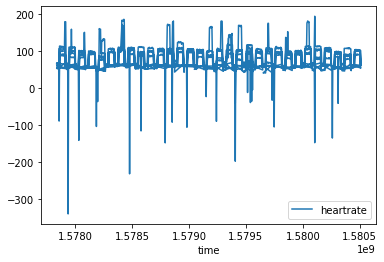

In [10]:
df_pandas.plot('time', 'heartrate')

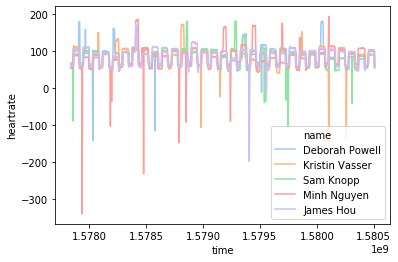

In [11]:
sns.set_palette(sns.color_palette("Paired", 9))
sns.lineplot(x="time", y="heartrate",
             hue="name", palette="pastel",
             data=df_pandas)

## Remove data from my silver layer

```console
/vagrant/hadoop/hadoop-3.2.1/bin/hadoop --config /vagrant/delta-lake-webinar/infra/etc/ fs -rm -r -f /user/chell/delta/silver
```

In [12]:
spark.sql('DROP TABLE IF EXISTS health_tracker_silver')

DataFrame[]

In [13]:
str_query= """CREATE TABLE health_tracker_silver
USING PARQUET 
PARTITIONED BY (p_device_id) 
LOCATION 'hdfs://192.168.33.10:9000/user/chell/delta/silver' 
AS (  
  SELECT name, 
         heartrate, 
         CAST(FROM_UNIXTIME(time) AS TIMESTAMP) AS time,  
         CAST(FROM_UNIXTIME(time) AS DATE) AS dte, 
         device_id AS p_device_id        
  FROM health_tracker_data_2020_01 
)"""

In [14]:
spark.sql(str_query)

DataFrame[]

In [15]:
spark.sql("select count(*) from health_tracker_silver").show()

+--------+
|count(1)|
+--------+
|    3720|
+--------+



In [16]:
spark.sql("select p_device_id,name, count(*) from health_tracker_silver group by p_device_id, name").show()

+-----------+--------------+--------+
|p_device_id|          name|count(1)|
+-----------+--------------+--------+
|          1|Kristin Vasser|     744|
|          0|Deborah Powell|     744|
|          3|   Minh Nguyen|     744|
|          2|     Sam Knopp|     744|
|          4|     James Hou|     744|
+-----------+--------------+--------+



In [17]:
spark.sql("DESCRIBE EXTENDED health_tracker_silver").show(truncate = False)

+----------------------------+-------------------------------------------------+-------+
|col_name                    |data_type                                        |comment|
+----------------------------+-------------------------------------------------+-------+
|name                        |string                                           |null   |
|heartrate                   |double                                           |null   |
|time                        |timestamp                                        |null   |
|dte                         |date                                             |null   |
|p_device_id                 |bigint                                           |null   |
|# Partition Information     |                                                 |       |
|# col_name                  |data_type                                        |comment|
|p_device_id                 |bigint                                           |null   |
|                    

In [18]:
from delta.tables import *

In [19]:
partitionedDeltaTable = DeltaTable.convertToDelta(spark, "parquet.`hdfs://192.168.33.10:9000/user/chell/delta/silver`", "p_device_id double")

spark.sql("""
CONVERT TO DELTA 
  parquet.`hdfs://192.168.33.10:9000/user/chell/delta/silver` 
  PARTITIONED BY (p_device_id double)
""")

In [20]:
spark.sql('DROP TABLE IF EXISTS health_tracker_silver')

DataFrame[]

In [21]:
spark.sql("""
CREATE TABLE health_tracker_silver
USING DELTA
LOCATION "hdfs://192.168.33.10:9000/user/chell/delta/silver"
""")

DataFrame[]

In [22]:
spark.sql("DESCRIBE EXTENDED health_tracker_silver").show(truncate = False)

+----------------------------+-------------------------------------------------+-------+
|col_name                    |data_type                                        |comment|
+----------------------------+-------------------------------------------------+-------+
|name                        |string                                           |null   |
|heartrate                   |double                                           |null   |
|time                        |timestamp                                        |null   |
|dte                         |date                                             |null   |
|p_device_id                 |double                                           |null   |
|                            |                                                 |       |
|# Detailed Table Information|                                                 |       |
|Database                    |dbacademy                                        |       |
|Table               

In [23]:
spark.sql('SELECT COUNT(*) FROM health_tracker_silver').show()

+--------+
|count(1)|
+--------+
|    3720|
+--------+



## Remove gold files

```console
/vagrant/hadoop/hadoop-3.2.1/bin/hadoop --config /vagrant/delta-lake-webinar/infra/etc/ fs -rm -r -f /user/chell/delta/gold
```

In [24]:
spark.sql('DROP TABLE IF EXISTS health_tracker_user_analytics')

DataFrame[]

In [25]:
spark.sql("""
CREATE TABLE health_tracker_user_analytics
USING DELTA
LOCATION 'hdfs://192.168.33.10:9000/user/chell/delta/gold/health_tracker_user_analytics'
AS (
  SELECT p_device_id, 
         AVG(heartrate) AS avg_heartrate,
         STD(heartrate) AS std_heartrate,
         MAX(heartrate) AS max_heartrate 
  FROM health_tracker_silver GROUP BY p_device_id
)
""")

DataFrame[]

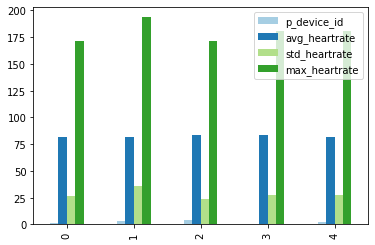

In [26]:
spark.sql('SELECT * FROM health_tracker_user_analytics').toPandas().plot.bar()

# Appending Files to an Existing Delta Table
* docs - https://docs.databricks.com/delta/quick-start.html
* community - https://docs.delta.io/latest/delta-update.html

In [27]:
spark.sql('SELECT COUNT(*) FROM health_tracker_silver').show()

+--------+
|count(1)|
+--------+
|    3720|
+--------+



In [28]:
spark.read.json("hdfs://192.168.33.10:9000/user/vagrant/delta/health_tracker_data_2020_02.json").createOrReplaceTempView("health_tracker_data_2020_02")

In [29]:
spark.sql('SELECT COUNT(*) FROM health_tracker_data_2020_02').show()

+--------+
|count(1)|
+--------+
|    3385|
+--------+



In [30]:
spark.sql("""
INSERT INTO health_tracker_silver
SELECT name,
       heartrate,
       CAST(FROM_UNIXTIME(time) AS TIMESTAMP) AS time,
       CAST(FROM_UNIXTIME(time) AS DATE) AS dte,
       CAST(device_id AS double) AS p_device_id
FROM health_tracker_data_2020_02
""")

DataFrame[]

In [31]:
spark.sql('SELECT COUNT(*) FROM health_tracker_silver').show()

+--------+
|count(1)|
+--------+
|    3720|
+--------+



In [32]:
str_query = """
SELECT name,
       heartrate,
       CAST(FROM_UNIXTIME(time) AS TIMESTAMP) AS time,
       CAST(FROM_UNIXTIME(time) AS DATE) AS dte,
       CAST(device_id AS double) as p_device_id
FROM health_tracker_data_2020_02
"""

In [33]:
spark.sql(str_query).write.format("delta").mode("append").save("hdfs://192.168.33.10:9000/user/chell/delta/silver")

In [34]:
spark.sql('SELECT COUNT(*) FROM health_tracker_silver').show()

+--------+
|count(1)|
+--------+
|    7105|
+--------+



In [35]:
spark.sql("DESCRIBE EXTENDED health_tracker_silver").show(truncate = False)

+----------------------------+-------------------------------------------------+-------+
|col_name                    |data_type                                        |comment|
+----------------------------+-------------------------------------------------+-------+
|name                        |string                                           |null   |
|heartrate                   |double                                           |null   |
|time                        |timestamp                                        |null   |
|dte                         |date                                             |null   |
|p_device_id                 |double                                           |null   |
|                            |                                                 |       |
|# Detailed Table Information|                                                 |       |
|Database                    |dbacademy                                        |       |
|Table               

spark.sql('SELECT COUNT(*) FROM health_tracker_silver VERSION AS OF 0').show()

In [36]:
spark.read.format("delta").option("versionAsOf", 0).load("hdfs://192.168.33.10:9000/user/chell/delta/silver").select('*').count()

3720

In [37]:
spark.sql('select count (*) from health_tracker_silver').show()

+--------+
|count(1)|
+--------+
|    7105|
+--------+



## Records by devices - Section 5

In [38]:
spark.sql('SELECT p_device_id, COUNT(*) FROM health_tracker_silver GROUP BY p_device_id').show()

+-----------+--------+
|p_device_id|count(1)|
+-----------+--------+
|        0.0|    1440|
|        1.0|    1440|
|        3.0|    1440|
|        4.0|    1345|
|        2.0|    1440|
+-----------+--------+



In [39]:
df_pandas = spark.sql('SELECT * FROM health_tracker_silver WHERE p_device_id IN (3, 4)').toPandas()

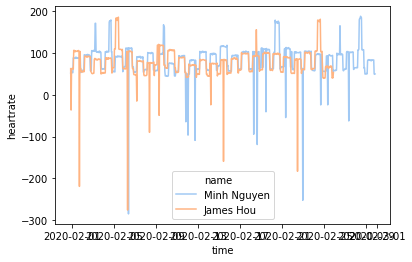

In [41]:
sns.lineplot(x="time", y="heartrate",
             hue="name", palette="pastel",
             data=df_pandas)

In [43]:
spark.sql('SELECT count(*) FROM health_tracker_silver WHERE heartrate < 0').show()

+--------+
|count(1)|
+--------+
|      67|
+--------+



docs - https://docs.databricks.com/spark/latest/spark-sql/language-manual/functions.html#lead

In [44]:
spark.sql("""
SELECT *, 
    LAG(heartrate) OVER (PARTITION BY p_device_id, dte ORDER BY p_device_id, dte) AS prev_amt, 
    LEAD(heartrate) OVER (PARTITION BY p_device_id, dte ORDER BY p_device_id, dte) AS next_amt 
    FROM health_tracker_silver
""").show()

+--------------+--------------+-------------------+----------+-----------+--------------+--------------+
|          name|     heartrate|               time|       dte|p_device_id|      prev_amt|      next_amt|
+--------------+--------------+-------------------+----------+-----------+--------------+--------------+
|Deborah Powell| 64.2449483513|2019-12-31 21:00:00|2019-12-31|        0.0|          null| 62.3352215777|
|Deborah Powell| 62.3352215777|2019-12-31 22:00:00|2019-12-31|        0.0| 64.2449483513| 62.6163048713|
|Deborah Powell| 62.6163048713|2019-12-31 23:00:00|2019-12-31|        0.0| 62.3352215777|          null|
|Deborah Powell| 63.2119937186|2020-01-01 00:00:00|2020-01-01|        0.0|          null| 63.9649771807|
|Deborah Powell| 63.9649771807|2020-01-01 01:00:00|2020-01-01|        0.0| 63.2119937186| 63.1313472184|
|Deborah Powell| 63.1313472184|2020-01-01 02:00:00|2020-01-01|        0.0| 63.9649771807|106.0817958086|
|Deborah Powell|106.0817958086|2020-01-01 03:00:00|2020

In [47]:
spark.stop()